# Deep Learning Project – Part 2: Improvements over Enhanced BiLSTM

This notebook builds **on Part 1** (reproduction of the paper *"Enhanced Bidirectional LSTM for Sentiment Analysis"*) and implements **practical improvements**:

1. **Class-weighted training** to handle severe label imbalance.
2. **Class-aware augmentation** (more aug for minority classes).
3. **(Bonus) BiLSTM with Attention** + class weights + class-aware augmentation.

**Instructions:**
- Upload `Stanford.csv` to Colab (same file used in Part 1).
- Run all cells in order.
- Compare the improved models with your Part 1 baseline results.


In [1]:
!pip install nltk --quiet

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, Bidirectional, LSTM,
    Dense, Dropout, BatchNormalization, Layer
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

nltk.download('wordnet')
nltk.download('omw-1.4')

print('TensorFlow version:', tf.__version__)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


TensorFlow version: 2.19.0


In [2]:
csv_path = '/content/Stanford.csv'  # adjust if needed

df = pd.read_csv(csv_path, engine='python')
print('Columns:', df.columns.tolist())
print('Original shape:', df.shape)

TEXT_COL = 'post_text'
LABEL_COL = 'Urgency_1_7'

df = df.dropna(subset=[TEXT_COL, LABEL_COL])
df = df[df[TEXT_COL].astype(str).str.strip().astype(bool)]
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce')
df = df.dropna(subset=[LABEL_COL])
df[LABEL_COL] = df[LABEL_COL].astype(int)

print('After NA cleanup:', df.shape)
df.head()


Columns: ['post_text', 'Urgency Practice', 'Urgency_1_7', 'CourseType']
Original shape: (29604, 4)
After NA cleanup: (29604, 4)


,post_text,Urgency Practice,Urgency_1_7,CourseType
0,Interesting! How often we say those things to ...,NaN,1,Education
1,"What is \Algebra as a Math Game\"" or are you j...",NaN,3,Education
2,I like the idea of my kids principal who says ...,NaN,2,Education
3,"From their responses, it seems the students re...",NaN,2,Education
4,"The boys loved math, because \there is freedom...",NaN,3,Education


In [3]:
def map_to_3_classes(score: int) -> int:
    if score > 4:
        return 2
    elif score < 4:
        return 0
    else:
        return 1

df['label_3'] = df[LABEL_COL].apply(map_to_3_classes)
print(df['label_3'].value_counts())
df[[TEXT_COL, LABEL_COL, 'label_3']].head()


label_3
0    23186
2     4744
1     1674
Name: count, dtype: int64


,post_text,Urgency_1_7,label_3
0,Interesting! How often we say those things to ...,1,0
1,"What is \Algebra as a Math Game\"" or are you j...",3,0
2,I like the idea of my kids principal who says ...,2,0
3,"From their responses, it seems the students re...",2,0
4,"The boys loved math, because \there is freedom...",3,0


In [4]:
lemmatizer = WordNetLemmatizer()
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
non_alpha_pattern = re.compile(r'[^a-zA-Z\s]')

def clean_text(text: str) -> str:
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = url_pattern.sub(' ', text)
    text = mention_pattern.sub(' ', text)
    text = non_alpha_pattern.sub(' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

df['clean_text'] = df[TEXT_COL].astype(str).apply(clean_text)
df[['clean_text', 'label_3']].head()


,clean_text,label_3
0,interesting how often we say those thing to ot...,0
1,what is algebra a a math game or are you just ...,0
2,i like the idea of my kid principal who say sm...,0
3,from their response it seems the student reall...,0
4,the boy loved math because there is freedom yo...,0


In [5]:
X = df['clean_text'].values
y = df['label_3'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

val_ratio_within_train = 1.0 / 6.0
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio_within_train,
    stratify=y_train_val,
    random_state=42
)

print('Train size:', len(X_train))
print('Val size   :', len(X_val))
print('Test size  :', len(X_test))


Train size: 17268
Val size   : 3454
Test size  : 8882


In [6]:
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN   = 150

def prepare_tokenizer_and_sequences(texts_train, texts_val, texts_test, max_len=MAX_SEQ_LEN):
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
    tokenizer.fit_on_texts(list(texts_train))

    def texts_to_padded(texts, tokenizer, max_len):
        seqs = tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(
            seqs,
            maxlen=max_len,
            padding='post',
            truncating='post'
        )
        return padded

    X_train_seq = texts_to_padded(texts_train, tokenizer, max_len)
    X_val_seq   = texts_to_padded(texts_val,   tokenizer, max_len)
    X_test_seq  = texts_to_padded(texts_test,  tokenizer, max_len)

    return tokenizer, X_train_seq, X_val_seq, X_test_seq, max_len

num_classes = 3
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat   = to_categorical(y_val,   num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

print('One-hot label shape (train):', y_train_cat.shape)
print('Max sequence length:', MAX_SEQ_LEN)


One-hot label shape (train): (17268, 3)
Max sequence length: 150


In [7]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

GLOVE_PATH = '/content/glove.6B.100d.txt'
EMBEDDING_DIM = 100

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found', len(embeddings_index), 'word vectors in GloVe.')


Found 400000 word vectors in GloVe.


In [8]:
def build_embedding_matrix(tokenizer, max_num_words, embedding_dim):
    word_index = tokenizer.word_index
    vocab_size = min(max_num_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

def build_bilstm_model(vocab_size, embedding_dim, embedding_matrix, max_len):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
        )
    )
    model.add(SpatialDropout1D(0.2))

    model.add(
        Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.3)
        )
    )
    model.add(BatchNormalization())

    model.add(
        Bidirectional(
            LSTM(64, dropout=0.3)
        )
    )
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='att_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='att_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = inputs * a
        output = tf.keras.backend.sum(output, axis=1)
        return output

def build_attention_bilstm_model(vocab_size, embedding_dim, embedding_matrix, max_len):
    from tensorflow.keras import Model, Input

    inp = Input(shape=(max_len,), name='input_ids')
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
    )(inp)
    x = SpatialDropout1D(0.2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = BatchNormalization()(x)

    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(x)
    x = BatchNormalization()(x)

    attn = AttentionLayer()(x)

    x = Dense(64, activation='relu')(attn)
    x = Dropout(0.5)(x)
    out = Dense(3, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def plot_history(history, title_prefix=''):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate_and_report(model, X_test_seq, y_test, y_test_cat, title=''):
    print(f'Evaluating on test set ({title})...')
    test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
    print(f'Test accuracy ({title}):', round(test_acc * 100, 2), '%')

    y_pred = np.argmax(model.predict(X_test_seq), axis=1)
    print(f'\nClassification Report ({title}):')
    print(classification_report(y_test, y_pred, digits=4))

    print(f'Confusion Matrix ({title}):')
    print(confusion_matrix(y_test, y_pred))

    return test_acc


In [9]:
classes = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight = {int(cls): float(w) for cls, w in zip(classes, class_weights_values)}
print('Class weights (from training data):', class_weight)


Class weights (from training data): {0: 0.4256137237503697, 1: 5.89150460593654, 2: 2.080231297434044}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.3415 - loss: 1.4038 - val_accuracy: 0.2423 - val_loss: 1.1014
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.3802 - loss: 1.1453 - val_accuracy: 0.3529 - val_loss: 1.0147
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.3580 - loss: 1.0761 - val_accuracy: 0.2444 - val_loss: 1.0692
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.3613 - loss: 1.0737 - val_accuracy: 0.6575 - val_loss: 0.9390
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4183 - loss: 1.0578 - val_accuracy: 0.1838 - val_loss: 1.3757
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.5336 - loss: 1.0244 - val_accuracy: 0.6714 - val_loss: 0.8121
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5832 - loss: 0.9588 - val_accuracy: 0.6355 - val_loss: 0.7976
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5824 - loss: 0.9395 - 

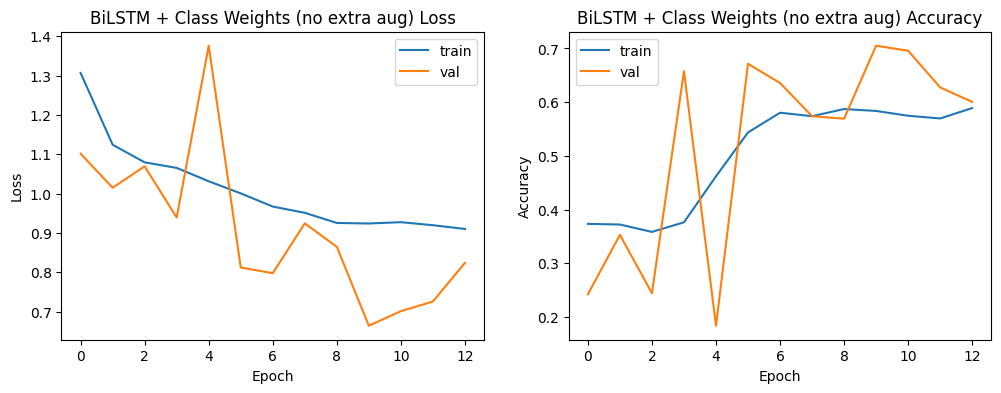

Evaluating on test set (BiLSTM + Class Weights (no extra aug))...
Test accuracy (BiLSTM + Class Weights (no extra aug)): 70.33 %
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Classification Report (BiLSTM + Class Weights (no extra aug)):
              precision    recall  f1-score   support

           0     0.9296    0.7324    0.8193      6957
           1     0.1096    0.1912    0.1393       502
           2     0.4182    0.7421    0.5350      1423

    accuracy                         0.7033      8882
   macro avg     0.4858    0.5552    0.4979      8882
weighted avg     0.8013    0.7033    0.7353      8882

Confusion Matrix (BiLSTM + Class Weights (no extra aug)):
[[5095  628 1234]
 [ 171   96  235]
 [ 215  152 1056]]


In [10]:
#Experiment 1 BiLSTM + Class Weights( no extra AUG)
#Training Standard BiLSTM with Class_weights
tokenizer_base, X_train_seq, X_val_seq, X_test_seq, max_len = prepare_tokenizer_and_sequences(
    X_train, X_val, X_test
)

embedding_matrix_base, vocab_size_base = build_embedding_matrix(
    tokenizer_base, MAX_NUM_WORDS, EMBEDDING_DIM
)

model_cw = build_bilstm_model(
    vocab_size_base, EMBEDDING_DIM, embedding_matrix_base, max_len
)
model_cw.summary()

early_stop_cw = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cw = model_cw.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop_cw],
    verbose=1,
    class_weight=class_weight,
)

plot_history(history_cw, title_prefix='BiLSTM + Class Weights (no extra aug)')

test_acc_cw = evaluate_and_report(
    model_cw, X_test_seq, y_test, y_test_cat,
    title='BiLSTM + Class Weights (no extra aug)'
)


In [11]:
#Class- Aware Augmentation Cell
#builds X_trained_balanced, y_trained_balanced with more aug for classes 1 & 2
def augment_sentence(sentence: str) -> str:
    words = sentence.split()
    if len(words) < 3:
        return sentence

    def get_synonyms(word):
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ').lower()
                if synonym != word:
                    synonyms.add(synonym)
        return list(synonyms)

    def synonym_replacement(words, n=1):
        words = words.copy()
        candidates = [w for w in words if len(get_synonyms(w)) > 0]
        random.shuffle(candidates)
        num_replaced = 0
        for word in candidates:
            syns = get_synonyms(word)
            if syns:
                synonym = random.choice(syns)
                idxs = [i for i, w in enumerate(words) if w == word]
                if idxs:
                    idx = random.choice(idxs)
                    words[idx] = synonym
                    num_replaced += 1
            if num_replaced >= n:
                break
        return words

    def random_deletion(words, p=0.1):
        if len(words) == 1:
            return words
        new_words = [w for w in words if random.uniform(0,1) > p]
        if len(new_words) == 0:
            return [random.choice(words)]
        return new_words

    def random_swap(words, n=1):
        words = words.copy()
        length = len(words)
        for _ in range(n):
            if length < 2:
                break
            i, j = random.sample(range(length), 2)
            words[i], words[j] = words[j], words[i]
        return words

    aug_type = random.choice(['sr', 'del', 'swap'])
    if aug_type == 'sr':
        words = synonym_replacement(words, n=1)
    elif aug_type == 'del':
        words = random_deletion(words, p=0.1)
    elif aug_type == 'swap':
        words = random_swap(words, n=1)

    return ' '.join(words)

random.seed(42)

X_train_balanced = []
y_train_balanced = []

for text, label in zip(X_train, y_train):
    X_train_balanced.append(text)
    y_train_balanced.append(label)

    if label == 0:
        if random.random() < 0.3:
            X_train_balanced.append(augment_sentence(text))
            y_train_balanced.append(label)

    elif label == 2:
        for _ in range(2):
            X_train_balanced.append(augment_sentence(text))
            y_train_balanced.append(label)

    elif label == 1:
        for _ in range(5):
            X_train_balanced.append(augment_sentence(text))
            y_train_balanced.append(label)

X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print('Original train size:', len(X_train))
print('Balanced train size:', len(X_train_balanced))
print('Balanced label distribution:')
print(pd.Series(y_train_balanced).value_counts())


Original train size: 17268
Balanced train size: 31769
Balanced label distribution:
0    17606
2     8301
1     5862
Name: count, dtype: int64


In [12]:
#recomputed Class Weights for Balanced Data
classes_bal = np.unique(y_train_balanced)
class_weights_values_bal = compute_class_weight(
    class_weight='balanced',
    classes=classes_bal,
    y=y_train_balanced
)
class_weight_bal = {int(cls): float(w) for cls, w in zip(classes_bal, class_weights_values_bal)}
print('Class weights (balanced train):', class_weight_bal)


Class weights (balanced train): {0: 0.6014805558711045, 1: 1.8064938018878653, 2: 1.2757097538449182}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.3673 - loss: 1.2810 - val_accuracy: 0.3483 - val_loss: 1.0561
Epoch 2/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.4654 - loss: 1.0353 - val_accuracy: 0.6578 - val_loss: 0.7842
Epoch 3/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5535 - loss: 0.9502 - val_accuracy: 0.5324 - val_loss: 0.8948
Epoch 4/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.5621 - loss: 0.9181 - val_accuracy: 0.6207 - val_loss: 0.7667
Epoch 5/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5857 - loss: 0.8872 - val_accuracy: 0.6453 - val_loss: 0.7201
Epoch 6/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6009 - loss: 0.8704 - val_accuracy: 0.5900 - val_loss: 0.7933
Epoch 7/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.6209 - loss: 0.8306 - val_accuracy: 0.6584 - val_loss: 0.6805
Epoch 8/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.6230 - loss: 0.8216 - 

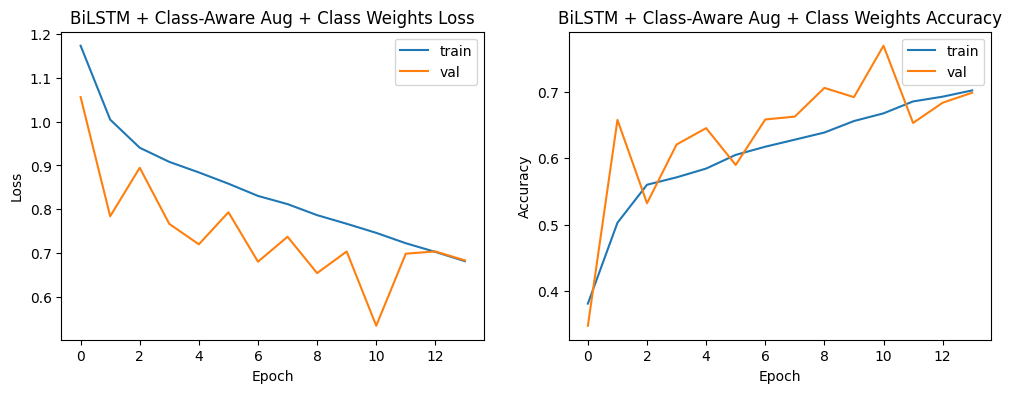

Evaluating on test set (BiLSTM + Class-Aware Aug + Class Weights)...
Test accuracy (BiLSTM + Class-Aware Aug + Class Weights): 77.11 %
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step

Classification Report (BiLSTM + Class-Aware Aug + Class Weights):
              precision    recall  f1-score   support

           0     0.9427    0.8203    0.8773      6957
           1     0.1517    0.3745    0.2160       502
           2     0.6004    0.6704    0.6335      1423

    accuracy                         0.7711      8882
   macro avg     0.5649    0.6217    0.5756      8882
weighted avg     0.8431    0.7711    0.8008      8882

Confusion Matrix (BiLSTM + Class-Aware Aug + Class Weights):
[[5707  785  465]
 [ 144  188  170]
 [ 203  266  954]]


In [13]:
#Experiment 2-BiLSTM + Class-Aware Aug + Class Weights
#Trains again and evaluates.
tokenizer_bal, X_train_bal_seq, X_val_bal_seq, X_test_bal_seq, max_len_bal = prepare_tokenizer_and_sequences(
    X_train_balanced, X_val, X_test
)

embedding_matrix_bal, vocab_size_bal = build_embedding_matrix(
    tokenizer_bal, MAX_NUM_WORDS, EMBEDDING_DIM
)

y_train_bal_cat = to_categorical(y_train_balanced, num_classes=num_classes)

model_bal = build_bilstm_model(
    vocab_size_bal, EMBEDDING_DIM, embedding_matrix_bal, max_len_bal
)
model_bal.summary()

early_stop_bal = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_bal = model_bal.fit(
    X_train_bal_seq, y_train_bal_cat,
    validation_data=(X_val_bal_seq, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop_bal],
    verbose=1,
    class_weight=class_weight_bal,
)

plot_history(history_bal, title_prefix='BiLSTM + Class-Aware Aug + Class Weights')

test_acc_bal = evaluate_and_report(
    model_bal, X_test_bal_seq, y_test, y_test_cat,
    title='BiLSTM + Class-Aware Aug + Class Weights'
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 150, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 150, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 150, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 150, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │           278 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,409,113 (9.19 MB)

 Trainable params: 408,345 (1.56 MB)

 Non-trainable params: 2,000,768 (7.63 MB)

Epoch 1/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.4118 - loss: 1.1483 - val_accuracy: 0.5640 - val_loss: 0.9295
Epoch 2/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.5297 - loss: 0.9764 - val_accuracy: 0.6222 - val_loss: 0.8819
Epoch 3/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5609 - loss: 0.9268 - val_accuracy: 0.6439 - val_loss: 0.7456
Epoch 4/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5850 - loss: 0.8957 - val_accuracy: 0.5165 - val_loss: 0.8856
Epoch 5/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6014 - loss: 0.8632 - val_accuracy: 0.5898 - val_loss: 0.8285
Epoch 6/20
497/497 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.6170 - loss: 0.8336 - val_accuracy: 0.5759 - val_loss: 0.8461


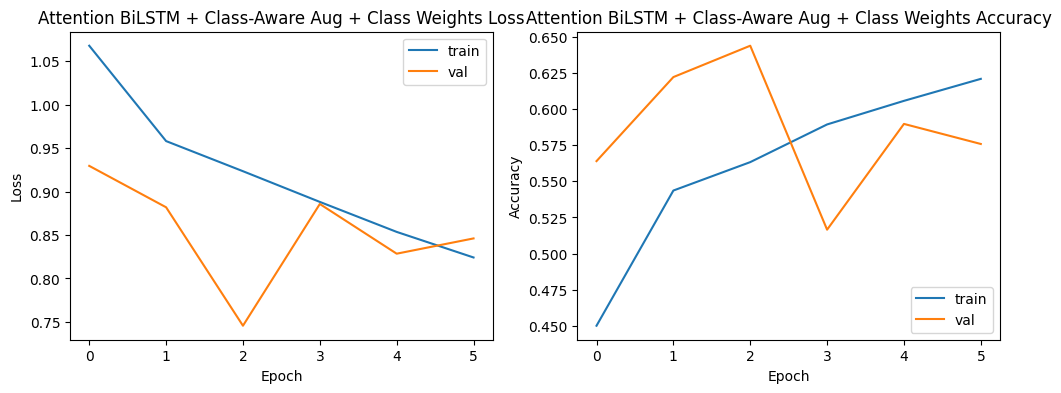

Evaluating on test set (Attention BiLSTM + Class-Aware Aug + Class Weights)...
Test accuracy (Attention BiLSTM + Class-Aware Aug + Class Weights): 63.71 %
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Classification Report (Attention BiLSTM + Class-Aware Aug + Class Weights):
              precision    recall  f1-score   support

           0     0.9416    0.6516    0.7702      6957
           1     0.0898    0.3367    0.1418       502
           2     0.4378    0.6725    0.5303      1423

    accuracy                         0.6371      8882
   macro avg     0.4897    0.5536    0.4808      8882
weighted avg     0.8128    0.6371    0.6963      8882

Confusion Matrix (Attention BiLSTM + Class-Aware Aug + Class Weights):
[[4533 1408 1016]
 [ 120  169  213]
 [ 161  305  957]]


In [14]:
#Experiment 3 – Attention BiLSTM + Class-Aware Aug + Class Weights (bonus)
#Trains the attention model and evaluates

model_attn = build_attention_bilstm_model(
    vocab_size_bal, EMBEDDING_DIM, embedding_matrix_bal, max_len_bal
)
model_attn.summary()

early_stop_attn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_attn = model_attn.fit(
    X_train_bal_seq, y_train_bal_cat,
    validation_data=(X_val_bal_seq, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop_attn],
    verbose=1,
    class_weight=class_weight_bal,
)

plot_history(history_attn, title_prefix='Attention BiLSTM + Class-Aware Aug + Class Weights')

test_acc_attn = evaluate_and_report(
    model_attn, X_test_bal_seq, y_test, y_test_cat,
    title='Attention BiLSTM + Class-Aware Aug + Class Weights'
)


In [15]:
summary_df = pd.DataFrame({
    'Setting': [
        'BiLSTM + Class Weights (no extra aug)',
        'BiLSTM + Class-Aware Aug + Class Weights',
        'Attention BiLSTM + Class-Aware Aug + Class Weights',
    ],
    'Test Accuracy': [
        test_acc_cw,
        test_acc_bal,
        test_acc_attn,
    ]
})

summary_df


,Setting,Test Accuracy
0,BiLSTM + Class Weights (no extra aug),0.703333
1,BiLSTM + Class-Aware Aug + Class Weights,0.771110
2,Attention BiLSTM + Class-Aware Aug + Class Wei...,0.637131


In [18]:

#  Single-sentence prediction helper


def predict_sentence(model, tokenizer, sentence, max_len=150):
    # Clean the input sentence using your preprocessing function
    cleaned = clean_text(sentence)

    # Convert to sequence
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Predict probabilities
    pred = model.predict(padded)
    label = np.argmax(pred)

    classes = {
        0: "Low Urgency",
        1: "Neutral Urgency",
        2: "High Urgency"
    }

    print("\n==============================")
    print("INPUT SENTENCE:")
    print(sentence)

    print("\nCLEANED VERSION:")
    print(cleaned)

    print("\nMODEL PREDICTION:")
    print("Class:", label, f"({classes[label]})")

    print("\nClass Probabilities:")
    print(f"Low:    {pred[0][0]:.4f}")
    print(f"Neutral:{pred[0][1]:.4f}")
    print(f"High:   {pred[0][2]:.4f}")
    print("==============================\n")


In [19]:
predict_sentence(model_bal, tokenizer_bal,
                 "Please respond quickly, this is very urgent!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

INPUT SENTENCE:
Please respond quickly, this is very urgent!

CLEANED VERSION:
please respond quickly this is very urgent

MODEL PREDICTION:
Class: 2 (High Urgency)

Class Probabilities:
Low:    0.3406
Neutral:0.0311
High:   0.6283



In [20]:
predict_sentence(model_cw, tokenizer_base,
                 "The assignment is due sometime next week.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

INPUT SENTENCE:
The assignment is due sometime next week.

CLEANED VERSION:
the assignment is due sometime next week

MODEL PREDICTION:
Class: 0 (Low Urgency)

Class Probabilities:
Low:    0.4837
Neutral:0.1932
High:   0.3231



In [21]:
predict_sentence(model_attn, tokenizer_bal,
                 "I will work on this later tonight.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

INPUT SENTENCE:
I will work on this later tonight.

CLEANED VERSION:
i will work on this later tonight

MODEL PREDICTION:
Class: 0 (Low Urgency)

Class Probabilities:
Low:    0.5309
Neutral:0.2586
High:   0.2106



In [22]:
predict_sentence(model_bal, tokenizer_bal,
                 "I think I will finish this task later, not urgent.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

INPUT SENTENCE:
I think I will finish this task later, not urgent.

CLEANED VERSION:
i think i will finish this task later not urgent

MODEL PREDICTION:
Class: 0 (Low Urgency)

Class Probabilities:
Low:    0.7489
Neutral:0.0952
High:   0.1558

